In [2]:
# Vol Surface Constructor

# 1/ Collect Data from YF
# 2/ Process and clean data
# 3/ Calculate IV
# 4/ Contsruct Vol Surface

In [3]:
# Updates

# Make the code more pythonic (use functions and call them rather than jsut blocks of code)
      # ---> made progress with this (almsot done)

# maybe add logic where we can mnaually remove outliers


# still dont fully understand RBF

# incorporate PDE into this model (algebraic continuation YT video on quant roadmap 2025)

In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from scipy.interpolate import Rbf
from sklearn.preprocessing import RobustScaler
import plotly.graph_objects as go

In [5]:
# INPUTS
ticker = 'SPY'
outlier_penalty = 1
k = 5   # no. of neighbours in KNN
smooth_input = 0.5  # used for RBF Interpolation
minIV = 0.0001

In [6]:
# Import data and convert into dataframe
def import_data(ticker):
    stock_data = yf.Ticker(ticker)
    expiration_dates = stock_data.options
    option_data = []

    # Loop through all expiration dates and collect the data
    for exp in expiration_dates:
        option_chain = stock_data.option_chain(exp)
        
        calls = option_chain.calls
        puts = option_chain.puts
        
        calls['expiration_date'] = exp
        calls['type'] = 'call'
        puts['expiration_date'] = exp
        puts['type'] = 'put'
        
        option_data.append(calls)
        option_data.append(puts)

    options_df = pd.DataFrame(pd.concat(option_data, ignore_index=True))

    return options_df

options_df = import_data(ticker)


In [7]:
# Data Cleaning

def clean_data(options_df):
    # Convert expiration date to datetime
    options_df["expiration_date"] = pd.to_datetime(options_df["expiration_date"])

    # remove rows with 'null' values
    options_df = options_df[~options_df.isnull().any(axis=1)]

    # drop duplicates
    options_df = options_df.drop_duplicates(subset="contractSymbol")

    # drop columns
    options_df.drop(columns=["lastTradeDate","change","percentChange","volume","inTheMoney","contractSize","currency"],inplace=True, errors="ignore")

    # Normalise strike price
    current_price = yf.Ticker(ticker).history(period="1d").Close.iloc[-1]
    options_df["moneyness"] = options_df["strike"] / current_price
    options_df = options_df[(options_df["moneyness"] <= 1.2) & (options_df["moneyness"] >= 0.8)]

    # time to maturity (+ filtering out long date options)
    options_df["time_to_maturity"] = (options_df.expiration_date - pd.to_datetime("today")).dt.days
    options_df = options_df[(options_df["time_to_maturity"] <= 180) & (options_df["time_to_maturity"] > 0)]

    # Filter out thinly traded options (low open interest)
    options_df = options_df[options_df.openInterest > 1000] # may need to change this -> this would need to change for diff tickers

    # Filter out extremely low IVs
    options_df = options_df[options_df["impliedVolatility"] > minIV]

    return options_df

options_df = clean_data(options_df)



In [8]:
# filter calls and puts

def option_type_filter(options_df, option_type):
    return options_df[options_df['type'] == option_type]


calls_df = option_type_filter(options_df, 'call')
puts_df = option_type_filter(options_df, 'put')

In [9]:
# Outlier Detection 

# step 1 -> standaridse moneyness and time to maturity as KNN is sensitive to scale

def outlier_detection(df, outlier_penalty):

    # Initialise the MinMaxScaler
    scaler = StandardScaler()

    # Normalise both features
    scaled_data = scaler.fit_transform(df[['moneyness', 'time_to_maturity']])

    IV = df['impliedVolatility'].values

    # Fit a KNN model to the feature data
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(scaled_data)

    # Find the k nearest neighbors for each point
    distances, indices = knn.kneighbors(scaled_data)

    # Calculate the average IV of the neighbors
    avg_IV_neighbors = []
    for i in range(len(df)):
        # Get the IVs of the k nearest neighbors
        neighbor_IVs = IV[indices[i]]
        avg_IV_neighbors.append(np.mean(neighbor_IVs))

    # Compute the difference between the IV of each point and its neighbors' average IV
    iv_diff = np.abs(IV - avg_IV_neighbors)

    # Define a threshold for outliers 
    threshold = outlier_penalty * np.std(iv_diff)

    # Flag outliers
    outliers = iv_diff > threshold

    # Add the 'Outlier' column to the DataFrame
    df['Outlier'] = outliers

    # df["Outlier_Adj_IV"] = np.where(df["Outlier"] == True, np.nan, df["impliedVolatility"])

    return df


outlier_detection(calls_df, outlier_penalty)
outlier_detection(puts_df, outlier_penalty)

C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_57052\2360725369.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier'] = outliers
C:\Users\HP Laptop\AppData\Local\Temp\ipykernel_57052\2360725369.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Outlier'] = outliers


,contractSymbol,strike,lastPrice,bid,ask,openInterest,impliedVolatility,expiration_date,type,moneyness,time_to_maturity,Outlier
41,SPY250113P00550000,550.0,0.01,0.01,0.02,6482.0,0.232430,2025-01-13,put,0.947475,1,True
44,SPY250113P00565000,565.0,0.05,0.04,0.05,1457.0,0.143075,2025-01-13,put,0.973316,1,True
45,SPY250113P00570000,570.0,0.13,0.13,0.14,3463.0,0.123544,2025-01-13,put,0.981929,1,True
46,SPY250113P00575000,575.0,0.60,0.60,0.61,5410.0,0.116220,2025-01-13,put,0.990542,1,True
47,SPY250113P00580000,580.0,2.10,2.06,2.09,4541.0,0.110849,2025-01-13,put,0.999156,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...
4231,SPY250630P00570000,570.0,17.59,18.29,18.37,1194.0,0.148095,2025-06-30,put,0.981929,169,False
4233,SPY250630P00580000,580.0,21.60,21.32,21.41,2340.0,0.136804,2025-06-30,put,0.999156,169,False
4234,SPY250630P00585000,585.0,23.11,23.08,23.18,1717.0,0.131158,2025-06-30,put,1.007769,169,False
4235,SPY250630P00590000,590.0,25.17,25.00,25.13,1339.0,0.125398,2025-06-30,put,1.016383,169,False


In [10]:
# create equivalent dataframes that exclude Outliers, this will be useful for interpolation
calls_df_no_nan = calls_df[calls_df.Outlier == False]
puts_df_no_nan = puts_df[puts_df.Outlier == False]



In [11]:
# RBFs

# It assigns each data point a weight that diminishes the further it is from the target (modelled by an RBF)
# Interpolated value at target point is then a weighted sum of the known values

In [12]:
# # this function requries 
#     # df with outliers
#     # df without outliers

# # Robust Scaler is used as it deals with outliers better (it works off IQR)

# def scaling(df, df_no_nan):
#     scaler = RobustScaler()

#     X_no_nan = df_no_nan[['moneyness', 'time_to_maturity']].values

#     X_scaled_no_nan = scaler.fit_transform(X_no_nan)

#     strike_grid_scaled = np.linspace(X_scaled_no_nan[:, 0].min(), X_scaled_no_nan[:, 0].max(), 50)
#     maturity_grid_scaled = np.linspace(X_scaled_no_nan[:, 1].min(), X_scaled_no_nan[:, 1].max(), 50)

#     X_scaled_grid, Y_scaled_grid = np.meshgrid(strike_grid_scaled, maturity_grid_scaled)

#     rbf = Rbf(X_scaled_no_nan[:, 0], X_scaled_no_nan[:, 1], df_no_nan['impliedVolatility'], function='linear', smooth=smooth_input)
#     Z_scaled = rbf(X_scaled_grid, Y_scaled_grid)

#     X_rescaled = scaler.inverse_transform(np.column_stack([X_scaled_grid.ravel(), Y_scaled_grid.ravel()]))  # Inverse scaling
#     X_rescaled = X_rescaled.reshape(X_scaled_grid.shape + (2,))  # Shape back into meshgrid dimensions

#     return scaler, Z_scaled, X_scaled_grid, Y_scaled_grid

# def construct_vol_surface(df, df_no_nan, X_scaled_grid, Y_scaled_grid, Z_scaled):

#     # Surface plot for the RBF interpolated implied volatility
#     surface = go.Surface(
#         x=scaling.X_rescaled[:, :, 0],  # Rescaled moneyness
#         y=scaling.X_rescaled[:, :, 1],  # Rescaled time to maturity
#         z=Z_scaled.reshape(scaling.X_scaled_grid.shape),  # Interpolated volatility
#         opacity=0.7,
#         name='Smoothed Surface',
#         colorscale="Jet"
#     )

#     # Define the scatter plot, using the 'Outlier_Int' for coloring
#     scatter = go.Scatter3d(
#         x=df['moneyness'],
#         y=df['time_to_maturity'],
#         z=df['impliedVolatility'],  # Using the original IV (includes outliers)
#         mode='markers',
#         marker=dict(
#             size=2,
#             color="black"),
#         text=df["Outlier"],
#         hovertemplate=(
#             'Moneyness: %{x}<br>'       
#             'Time to Maturity: %{y}<br>'
#             'Implied Volatility: %{z}<br>'
#             'Outlier: %{text}<br>'))

#     fig = go.Figure(data=[scatter, surface])
#     fig.update_layout(
#             title="Volatility Surface - {ticker}",
#             scene=dict(
#             xaxis_title='Moneyness',
#             yaxis_title='Time to Maturity',
#             zaxis_title='Implied Volatility'))

#     fig.show()

#     return Z_scaled




# construct_vol_surface(calls_df, calls_df_no_nan)
# construct_vol_surface(puts_df, puts_df_no_nan)

In [13]:
calls_df

,contractSymbol,strike,lastPrice,bid,ask,openInterest,impliedVolatility,expiration_date,type,moneyness,time_to_maturity,Outlier
6,SPY250113C00585000,585.0,0.61,0.60,0.61,1365.0,0.102182,2025-01-13,call,1.007769,1,True
9,SPY250113C00588000,588.0,0.17,0.17,0.18,1533.0,0.099130,2025-01-13,call,1.012937,1,True
10,SPY250113C00589000,589.0,0.10,0.11,0.12,1381.0,0.099618,2025-01-13,call,1.014660,1,False
11,SPY250113C00590000,590.0,0.07,0.06,0.07,3973.0,0.098154,2025-01-13,call,1.016383,1,False
12,SPY250113C00591000,591.0,0.05,0.04,0.05,1341.0,0.100595,2025-01-13,call,1.018105,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
4112,SPY250630C00655000,655.0,2.24,2.27,2.28,1209.0,0.131021,2025-06-30,call,1.128357,169,False
4114,SPY250630C00665000,665.0,1.50,1.42,1.44,9160.0,0.128427,2025-06-30,call,1.145584,169,False
4115,SPY250630C00670000,670.0,1.15,1.13,1.15,1497.0,0.127694,2025-06-30,call,1.154197,169,False
4116,SPY250630C00675000,675.0,0.91,0.89,0.91,5135.0,0.126901,2025-06-30,call,1.162811,169,False


In [14]:
from sklearn.preprocessing import RobustScaler
from scipy.interpolate import Rbf
import numpy as np
import plotly.graph_objects as go

def construct_vol_surface(df, df_no_nan, smooth_input):
    # Initialize scaler
    scaler = RobustScaler()

    # Scaling the moneyness and time_to_maturity features
    X_no_nan = df_no_nan[['moneyness', 'time_to_maturity']].values
    X_scaled_no_nan = scaler.fit_transform(X_no_nan)

    # Create a grid for scaling
    strike_grid_scaled = np.linspace(X_scaled_no_nan[:, 0].min(), X_scaled_no_nan[:, 0].max(), 50)
    maturity_grid_scaled = np.linspace(X_scaled_no_nan[:, 1].min(), X_scaled_no_nan[:, 1].max(), 50)

    X_scaled_grid, Y_scaled_grid = np.meshgrid(strike_grid_scaled, maturity_grid_scaled)

    # RBF interpolation on the scaled grid
    rbf = Rbf(X_scaled_no_nan[:, 0], X_scaled_no_nan[:, 1], df_no_nan['impliedVolatility'], function='linear', smooth=smooth_input)
    Z_scaled = rbf(X_scaled_grid, Y_scaled_grid)

    # Return the scaler and necessary data for 3D plot and future 2D plot
    return scaler, X_scaled_no_nan, df_no_nan['impliedVolatility'], Z_scaled, X_scaled_grid, Y_scaled_grid







In [ ]:
# Retrieve the scaling information from construct_vol_surface
scaler, X_scaled_no_nan, y_scaled, Z_scaled, X_scaled_grid, Y_scaled_grid = construct_vol_surface(calls_df, calls_df_no_nan, smooth_input)

# Combine X_scaled_grid and Y_scaled_grid for inverse transformation
grid_scaled_combined = np.column_stack([X_scaled_grid.ravel(), Y_scaled_grid.ravel()])

# Rescale back to original values using the same scaler
X_rescaled, Y_rescaled = scaler.inverse_transform(grid_scaled_combined).T

# Reshape the rescaled values back to grid shapes
X_rescaled = X_rescaled.reshape(X_scaled_grid.shape)
Y_rescaled = Y_rescaled.reshape(Y_scaled_grid.shape)

# Surface plot for the RBF interpolated implied volatility
surface = go.Surface(
    x=X_rescaled,  # Rescaled moneyness
    y=Y_rescaled,  # Rescaled time to maturity
    z=Z_scaled,  # Interpolated volatility
    opacity=0.7,
    name='Smoothed Surface',
    colorscale="Jet"
)

# Define the scatter plot for original IV data (with outliers)
scatter = go.Scatter3d(
    x=calls_df['moneyness'],
    y=calls_df['time_to_maturity'],
    z=calls_df['impliedVolatility'],
    mode='markers',
    marker=dict(
        size=2,
        color="black"),
    text=calls_df["Outlier"],
    hovertemplate=(
        'Moneyness: %{x}<br>'       
        'Time to Maturity: %{y}<br>'
        'Implied Volatility: %{z}<br>'
        'Outlier: %{text}<br>'))

# Plot the data
fig = go.Figure(data=[scatter, surface])
fig.update_layout(
    title="Volatility Surface",
    scene=dict(
        xaxis_title='Moneyness',
        yaxis_title='Time to Maturity',
        zaxis_title='Implied Volatility'))
fig.show()
w

In [25]:
# model IVs

Z_scaled # shape (50,50)



array([[0.67568829, 0.66253482, 0.64349703, ..., 0.36481821, 0.3632201 ,
        0.36269741],
       [0.67103101, 0.6568374 , 0.63685805, ..., 0.35631174, 0.35345677,
        0.35317075],
       [0.66084262, 0.64703453, 0.62725719, ..., 0.34271492, 0.34200136,
        0.34272351],
       ...,
       [0.38752713, 0.37071703, 0.3575268 , ..., 0.13139626, 0.13571388,
        0.14290222],
       [0.38853484, 0.37244099, 0.35916379, ..., 0.13353484, 0.13839659,
        0.14590357],
       [0.38990927, 0.37435584, 0.36111225, ..., 0.13612207, 0.14143958,
        0.14910396]], shape=(50, 50))

In [20]:

calls_df.impliedVolatility

6       0.102182
9       0.099130
10      0.099618
11      0.098154
12      0.100595
          ...   
4112    0.131021
4114    0.128427
4115    0.127694
4116    0.126901
4117    0.126657
Name: impliedVolatility, Length: 570, dtype: float64

In [24]:
X_rescaled

array([[0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ],
       [0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ],
       [0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ],
       ...,
       [0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ],
       [0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ],
       [0.81827423, 0.82600872, 0.83374322, ..., 1.18179541, 1.18952991,
        1.1972644 ]], shape=(50, 50))

In [23]:
Y_rescaled

array([[  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  4.42857143,   4.42857143,   4.42857143, ...,   4.42857143,
          4.42857143,   4.42857143],
       [  7.85714286,   7.85714286,   7.85714286, ...,   7.85714286,
          7.85714286,   7.85714286],
       ...,
       [162.14285714, 162.14285714, 162.14285714, ..., 162.14285714,
        162.14285714, 162.14285714],
       [165.57142857, 165.57142857, 165.57142857, ..., 165.57142857,
        165.57142857, 165.57142857],
       [169.        , 169.        , 169.        , ..., 169.        ,
        169.        , 169.        ]], shape=(50, 50))

In [28]:
print(X_rescaled[0])

[0.81827423 0.82600872 0.83374322 0.84147771 0.8492122  0.8569467
 0.86468119 0.87241568 0.88015018 0.88788467 0.89561916 0.90335366
 0.91108815 0.91882264 0.92655714 0.93429163 0.94202612 0.94976062
 0.95749511 0.9652296  0.9729641  0.98069859 0.98843308 0.99616758
 1.00390207 1.01163656 1.01937106 1.02710555 1.03484004 1.04257453
 1.05030903 1.05804352 1.06577801 1.07351251 1.081247   1.08898149
 1.09671599 1.10445048 1.11218497 1.11991947 1.12765396 1.13538845
 1.14312295 1.15085744 1.15859193 1.16632643 1.17406092 1.18179541
 1.18952991 1.1972644 ]


In [29]:
Z_scaled

array([[0.67568829, 0.66253482, 0.64349703, ..., 0.36481821, 0.3632201 ,
        0.36269741],
       [0.67103101, 0.6568374 , 0.63685805, ..., 0.35631174, 0.35345677,
        0.35317075],
       [0.66084262, 0.64703453, 0.62725719, ..., 0.34271492, 0.34200136,
        0.34272351],
       ...,
       [0.38752713, 0.37071703, 0.3575268 , ..., 0.13139626, 0.13571388,
        0.14290222],
       [0.38853484, 0.37244099, 0.35916379, ..., 0.13353484, 0.13839659,
        0.14590357],
       [0.38990927, 0.37435584, 0.36111225, ..., 0.13612207, 0.14143958,
        0.14910396]], shape=(50, 50))

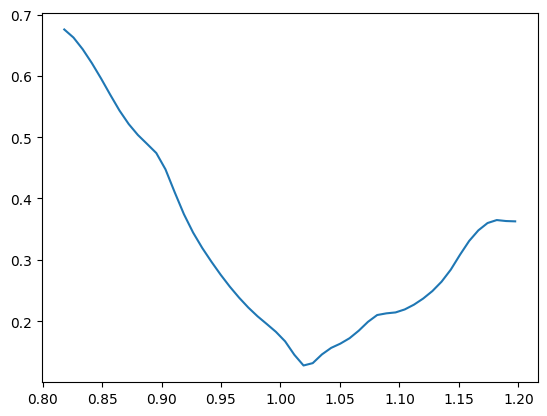

In [32]:
plt.plot(X_rescaled[0], Z_scaled[0])

In [33]:
# Choose a fixed time to maturity value (you can choose any value from the grid)
fixed_time_to_maturity = 0.5  # For example, fix time_to_maturity at 0.5

# Find the corresponding index in the Y grid for this time to maturity value
time_to_maturity_index = np.argmin(np.abs(Y_scaled_grid[0, :] - fixed_time_to_maturity))

# Extract the interpolated implied volatility for this fixed time to maturity value (along moneyness)
iv_vs_moneyness = Z_scaled[:, time_to_maturity_index]

# Rescale moneyness back to original scale (make sure it's a 1D array for inverse_transform)
moneyness_rescaled = scaler.inverse_transform(X_scaled_grid[0, :].reshape(-1, 1))  # X_scaled_grid[0, :] selects the row for moneyness

# Plot 2D graph
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(
    x=moneyness_rescaled.flatten(),
    y=iv_vs_moneyness,
    mode='lines',
    name=f'Implied Volatility vs Moneyness (T={fixed_time_to_maturity})',
    line=dict(color='blue')
))

# Add labels and title
fig.update_layout(
    title=f'Implied Volatility vs Moneyness (Time to Maturity = {fixed_time_to_maturity})',
    xaxis_title="Moneyness",
    yaxis_title="Implied Volatility"
)

fig.show()


ValueError: non-broadcastable output operand with shape (50,1) doesn't match the broadcast shape (50,2)